In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
import pandas as pd
import numpy as np
from datetime import datetime
import time

In [2]:
table_tmp = np.genfromtxt('../calibrators/Hriz_3sigClip.csv' , delimiter=',', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc_drop_riz = table_tmp['PGC']

table_tmp = np.genfromtxt('../calibrators/Hw1_3sigClip.csv' , delimiter=',', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc_drop_w1 = table_tmp['PGC']

In [3]:
drop = np.genfromtxt('../calibrators/TF_drop.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc_drop = drop['PGC']

faint = np.genfromtxt('../calibrators/TF_faint.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc_faint = faint['PGC']

pgc_reject = np.concatenate((pgc_drop, pgc_faint))
pgc_reject = np.unique(pgc_reject)

In [4]:
#################################################################
def Vh2V3k(el,b, Vh):
  
    alpha = np.pi / 180.
    cosb = np.cos(b*alpha)
    sinb = np.sin(b*alpha)
    cosl = np.cos(el*alpha)
    sinl = np.sin(el*alpha)
    
    v3k = Vh-25.2*cosl*cosb-245.7*sinl*cosb+276.8*sinb

    return v3k

#################################################################

def Vcmb2Vmod(Vcmb, omegam=0.27):
    
    omegal=1.-omegam
    c=299800.
    z=Vcmb/c
    q0=0.5*(omegam-2.*omegal)
    fmod=1.+0.5*(1.-q0)*z-(1./6)*(1.-q0-3.*q0**2+1.)*z**2
    Vmod=c*z*fmod

    return Vmod
#################################################################

def Vh2Vls(el,b, Vh):
  
    alpha = np.pi / 180.
    cosb = np.cos(b*alpha)
    sinb = np.sin(b*alpha)
    cosl = np.cos(el*alpha)
    sinl = np.sin(el*alpha)
    
    vls = Vh-26.*cosl*cosb+317.*sinl*cosb-8.*sinb

    return vls
#################################################################

In [5]:
df = pd.read_csv('all_cf2_tfr.csv', delimiter='|')
df = df.rename(columns=lambda x: x.strip())
df_allcf2 = df.set_index('PGC')

df_allcf2.loc[5341]['PGC1']  = 5663

df_allcf2['eDM_allcf2'] = df_allcf2.DM * 0. + 0.40
df_allcf2 = df_allcf2.rename(columns={"DM": "DM_allcf2"})
df_allcf2 = df_allcf2.rename(columns={"PGC1": "PGC1_allcf2"})
df_allcf2 = df_allcf2.rename(columns={"Nest": "Nest_allcf2"})
df_allcf2 = df_allcf2.rename(columns={"Vcmb": "Vcmb_allcf2"})

/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [6]:
df = pd.read_csv('all_cf2_tfr.csv', delimiter='|')
df = df.rename(columns=lambda x: x.strip())
df_sfi = df.set_index('PGC')

df_sfi.loc[5341]['PGC1']  = 5663

df_sfi["eDM_sfi"] = df_sfi.DM * 0. + 0.39
df_sfi = df_sfi.rename(columns={"DMsfi": "DM_sfi"})

df_sfi["DM_sfi"][df_sfi["DM_sfi"]==0] = np.nan
df_sfi["eDM_sfi"][df_sfi["DM_sfi"].isna()] = np.nan
del df_sfi['DM']
df_sfi = df_sfi.rename(columns={"PGC1": "PGC1_sfi"})
df_sfi = df_sfi.rename(columns={"Nest": "Nest_sfi"})
df_sfi = df_sfi.rename(columns={"Vcmb": "Vcmb_sfi"})

/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by Int

In [7]:
df = pd.read_csv('all_cf2_tfr.csv', delimiter='|')
df = df.rename(columns=lambda x: x.strip())
df_cf2 = df.set_index('PGC')

df_cf2.loc[5341]['PGC1']  = 5663

df_cf2["eDM_cf2"] = df_cf2.DM * 0. + 0.41
df_cf2 = df_cf2.rename(columns={"DMcf2": "DM_cf2"})

df_cf2["DM_cf2"][df_cf2["DM_cf2"]==0] = np.nan
df_cf2["eDM_cf2"][df_cf2["DM_cf2"].isna()] = np.nan
del df_cf2['DM']
df_cf2 = df_cf2.rename(columns={"PGC1": "PGC1_cf2"})
df_cf2 = df_cf2.rename(columns={"Nest": "Nest_cf2"})
df_cf2 = df_cf2.rename(columns={"Vcmb": "Vcmb_cf2"})

/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by Int

In [8]:
df = pd.read_csv('spitzer_cf3_tfr.csv', delimiter='|')
df = df.rename(columns=lambda x: x.strip())
df_spitzer = df.set_index('PGC')

df_spitzer.loc[5341]['PGC1']  = 5663

ln10 = np.log(10.)
df_spitzer['DM_spitzer']  = (5*np.log10(df_spitzer.Dcf3)+25.)
df_spitzer['eDM_spitzer'] = 5*df_spitzer.eD/df_spitzer.Dcf3/ln10
df_spitzer = df_spitzer.rename(columns={"pgc1": "PGC1_spitzer"})
df_spitzer = df_spitzer.rename(columns={"Nest": "Nest_spitzer"})
df_spitzer = df_spitzer.rename(columns={"Vcmb": "Vcmb_spitzer"})

df_spitzer["eDM_spitzer"] = df_spitzer["DM_spitzer"]*0 + 0.44

df_spitzer["eDM_spitzer"][df_spitzer['C']==1] = 0.40   # color adjusted
df_spitzer["eDM_spitzer"][df_spitzer['C']==0] = 0.50   # otherwise

/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/ehsan/anaconda3/envs/py2/lib/python2.7/site-packages/pandas/core/series.py:1015: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc[key] = value
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/media/Data/Home/anaconda3/envs/py

In [9]:
df = pd.read_csv('2mtf.csv', delimiter='|')
df = df.rename(columns=lambda x: x.strip())
df_2mtf = df.set_index('PGC')

df_2mtf.loc[5341]['PGC1']  = 5663

df_2mtf = df_2mtf.rename(columns={"DMadj":"DM_2mtf", "eDM":"eDM_2mtf"})
df_2mtf = df_2mtf.rename(columns={"PGC1": "PGC1_2mtf"})
df_2mtf = df_2mtf.rename(columns={"Nest": "Nest_2mtf"})

df_2mtf["eDM_2mtf"] = df_2mtf["DM_2mtf"]*0 + 0.50

df_2mtf['Vls_2mtf'] = Vh2Vls(df_2mtf["glon"], df_2mtf["glat"], df_2mtf["cz2m"])  # using 2mass cz
df_2mtf = df_2mtf.rename(columns={"cz2m": "Vcmb_2mtf"})

df_2mtf = df_2mtf[df_2mtf['Vls_2mtf']>2000]

df_2mtf.head()

/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Name,Dadj,DM_2mtf,eDM_2mtf,2mass,RA,Dec,Vcmb_2mtf,Ktc,Htc,...,Kt,V,Ag,Nest_2mtf,PGC1_2mtf,Ng,Vgm,Sigp,R2t,Vls_2mtf
PGC,,,,,,,,,,,,,,,,,,,,,
70,UGC12900,120.4,35.402,0.5,00005604+2020165,0.23345,20.33799,6804,11.124,11.616,...,11.19,6804,0.34,209949,70,1,6561,122,0.249,7043.671642
76,UGC12901,106.9,35.146,0.5,00005891+2854421,0.24550,28.91172,6899,10.818,11.085,...,10.89,6896,0.21,209247,76,1,6676,139,0.282,7161.795767
80,IC5375,134.8,35.648,0.5,00010478+0432261,0.26987,4.54060,9151,11.029,11.274,...,11.06,9223,0.13,207489,80,1,8992,182,0.371,9334.386184
102,IC5376,84.0,34.621,0.5,00011976+3431326,0.33238,34.52571,5032,10.405,10.704,...,10.47,5029,0.31,210310,102,1,4769,114,0.232,5306.650853
120,UGC12914,98.3,34.963,0.5,00013830+2329011,0.40968,23.48363,4371,9.330,9.591,...,9.39,4349,0.48,202766,120,2,4048,170,0.345,4619.483569


In [10]:
df = pd.read_csv('6dfgs.csv', delimiter='|')
df = df.rename(columns=lambda x: x.strip())
df_6dfgs = df.set_index('PGC')

ln10 = np.log(10.)
df_6dfgs['DM_6dfgs']  = (5*np.log10(df_6dfgs["D75"])+25.)
df_6dfgs['eDM_6dfgs'] = 5.*df_6dfgs["feD"]/ln10
df_6dfgs = df_6dfgs.rename(columns={"Nest": "Nest_6dfgs"})
df_6dfgs = df_6dfgs.rename(columns={"Vcmb": "Vcmb_6dfgs"})

# df_6dfgs.head()

In [11]:
df = pd.read_csv('flat_tfr.csv', delimiter='|')
df = df.rename(columns=lambda x: x.strip())
df_flat = df.set_index('PGC')

df_flat["eDM_flat"] = df_flat.DMadj * 0. + 0.55

df_flat = df_flat.rename(columns={"DMadj":"DM_flat"})
df_flat = df_flat.rename(columns={"PGC1": "PGC1_flat"})
df_flat = df_flat.rename(columns={"Nest": "Nest_flat"})
df_flat = df_flat.rename(columns={"Vcmb": "Vcmb_flat"})

df_flat.head(10)

,DM_flat,DMbig,DMfull,Vh,Vls,Vcmb_flat,Vmod,f,PGC1_flat,Nest_flat,glon,glat,sgl,sgb,DMg,eDMg,eDM_flat
PGC,,,,,,,,,,,,,,,,,
70,35.384,34.817,34.859,6800,7040,6447,6557,1.017,70,209949,107.1780,-40.9837,313.2487,17.7662,35.12,0.12,0.55
642,33.097,32.780,32.572,4441,4718,4130,4175,1.011,642,210102,113.6137,-24.6495,331.3316,18.5421,34.06,0.19,0.55
731,35.444,34.926,34.919,7059,7318,6725,6845,1.018,791,200264,112.2328,-33.0307,322.5668,17.0954,35.23,0.13,0.55
978,33.699,33.290,33.174,5399,5626,5049,5116,1.013,978,207997,110.8971,-43.4288,312.1216,14.2463,34.33,0.16,0.55
1422,34.619,34.141,34.094,5663,5893,5319,5393,1.014,1351,200045,113.7645,-41.7438,314.5450,12.9247,34.59,0.14,0.55
1609,34.076,33.569,33.551,5329,5470,4982,5047,1.013,1609,209583,107.9640,-64.4089,292.2505,6.4025,33.81,0.16,0.55
1751,34.728,34.253,34.203,7640,7756,7301,7441,1.019,1751,0,106.4509,-69.5238,287.5157,4.3315,35.02,0.23,0.55
1797,35.120,34.575,34.595,6350,6605,6030,6126,1.016,1736,200470,117.4270,-31.2540,325.7199,13.4560,34.80,0.14,0.55
2231,34.029,33.552,33.504,5293,5538,4971,5037,1.013,2298,200380,119.2386,-33.6215,323.8154,11.3388,34.09,0.16,0.55


In [12]:
df = pd.read_csv('../calibrators/DMs_EDD.csv.test', delimiter='|')
df = df.rename(columns=lambda x: x.strip())
df = df.rename(columns=lambda x: x if x!='DM_w1' else 'DMw1')
df = df.rename(columns=lambda x: x if x!='dDM_w1' else 'dDMw1')
df = df.rename(columns=lambda x: x if x!='pgc' else 'PGC')
df = df.set_index('PGC')

df.loc[69095]['PGC1']  = 69148


## Using hugh quality distances, photoemtry, etc to determine zero points
df_cf4tfr = df[((((df['Sqlt']>2) & ~df.index.isin(pgc_drop_riz)) | 
          ((df['Wqlt']>2) & ~df.index.isin(pgc_drop_w1))) & 
          (~df.index.isin(pgc_reject)) &
          (df['DM_src']>0)
               )]

df_cf4tfr = df_cf4tfr.rename(columns={"pgc1": "PGC1_cf4", 
                                      "Nest": "Nest_cf4",
                                      "DM_best":"DM_cf4", 
                                      "dDM_best":"eDM_cf4"})


df_cf4tfr["eDM_cf4"][df_cf4tfr['DM_src']==1] = 0.37
df_cf4tfr["eDM_cf4"][df_cf4tfr['DM_src']==2] = 0.39

df_cf4tfr = df_cf4tfr.rename(columns={"V3k": "Vcmb_cf4"})

len(df_cf4tfr)

/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


9690

In [13]:
how = 'outer'
df = df_cf4tfr.join(df_allcf2, lsuffix='_cf4', rsuffix='_allcf2', how=how)
df = df.join(df_cf2, lsuffix='_l1', rsuffix='_cf2', how=how)
df = df.join(df_sfi, lsuffix='_l2', rsuffix='_sfi', how=how)
df = df.join(df_spitzer, lsuffix='_l3', rsuffix='_spitzer', how=how)
df = df.join(df_2mtf, lsuffix='_l4', rsuffix='_2mtf', how=how)
df = df.join(df_flat, lsuffix='_l5', rsuffix='_flat', how=how)

# df = df.join(df_6dfgs, lsuffix='_l5', rsuffix='_6dfgs', how=how)


for col in df.columns:
    if col.split('_')[0]=='PGC1' and col!='PGC1_cf4':
        df['PGC1_cf4'] = df['PGC1_cf4'].fillna(df[col])
        
for col in df.columns:
    if col.split('_')[0]=='Nest' and col!='Nest_cf4':
        df['Nest_cf4'] = df['Nest_cf4'].fillna(df[col])

catalogs = ["cf4", "spitzer", "cf2", "sfi", "2mtf", "flat"] # , "allcf2"] #  #, "2mtf"] # , "6dfgs"]

ss = []
for cat in catalogs:
    ss += ['PGC1_'+cat, 'Nest_'+cat, "DM_"+cat, "eDM_"+cat, "Vcmb_"+cat]

df = df[ss]

print(len(df))


df.head(11)

12569


,PGC1_cf4,Nest_cf4,DM_cf4,eDM_cf4,Vcmb_cf4,PGC1_spitzer,Nest_spitzer,DM_spitzer,eDM_spitzer,Vcmb_spitzer,...,PGC1_2mtf,Nest_2mtf,DM_2mtf,eDM_2mtf,Vcmb_2mtf,PGC1_flat,Nest_flat,DM_flat,eDM_flat,Vcmb_flat
PGC,,,,,,,,,,,,,,,,,,,,,
2,73150.0,200275.0,34.24,0.39,4726.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,120.0,202766.0,33.29,0.37,4109.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,12.0,210177.0,35.03,0.39,6195.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,16.0,211419.0,34.70,0.37,5312.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,55.0,0.0,34.00,0.37,4454.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,68.0,0.0,34.81,0.37,7338.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,70.0,209949.0,35.12,0.37,6447.0,NaN,NaN,NaN,NaN,NaN,...,70.0,209949.0,35.402,0.5,6804.0,70.0,209949.0,35.384,0.55,6447.0
76,76.0,209247.0,34.73,0.37,6583.0,NaN,NaN,NaN,NaN,NaN,...,76.0,209247.0,35.146,0.5,6899.0,NaN,NaN,NaN,NaN,NaN
80,80.0,207489.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80.0,207489.0,35.648,0.5,9151.0,NaN,NaN,NaN,NaN,NaN


In [14]:
for cat in catalogs:
    df['Vmod_'+cat] = Vcmb2Vmod(df['Vcmb_'+cat])
    logD = (df['DM_'+cat]-25)/5.
    df['logH_'+cat] = np.log10(df['Vmod_'+cat]) - logD 
    
    print cat, 10**df['logH_'+cat][df['Vmod_'+cat]>4000].median()

cf4 74.71127684346841
spitzer 72.70981611169202
cf2 72.21169260070033
sfi 73.01629464566868
2mtf 74.81187678527034
flat 70.09331862587285


/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


In [15]:
sigmaClips = {}

for i in range(1):
    for cat in catalogs:

        logH = df['logH_'+cat]
        med = logH[df['Vmod_'+cat]>4000].median()
        stdev = logH[df['Vmod_'+cat]>4000].std()
        
#         print cat, 10**med
        
        if not cat in sigmaClips:
                sigmaClips[cat] = []
        sigmaClips[cat] += list(df[(logH > med+3.5*stdev) | (logH < med-3.5*stdev)].index.values)
        df['DM_'+cat][(logH > med+3.5*stdev) | (logH < med-3.5*stdev)] = np.nan
        df['eDM_'+cat][(logH > med+3.5*stdev) | (logH < med-3.5*stdev)] = np.nan
        df['logH_'+cat][(logH > med+3.5*stdev) | (logH < med-3.5*stdev)] = np.nan


In [16]:
myDict = {}
myDict['cf4'] = 0

for cat in catalogs[1:]:

        delta = df['DM_cf4'] - df['DM_'+cat]

        stdev = delta.std()
        med   = delta.median()
        myDict[cat] = med

In [17]:
for j in range(10):    
    for cat in catalogs:
        df['w_'+cat] = 1./df['eDM_'+cat]**2
        df['xw_'+cat] = (df['logH_'+cat]-0.2*myDict[cat])*df['w_'+cat]
        df['vw_'+cat] = (df['Vmod_'+cat])*df['w_'+cat]
#         print cat, 10**(df['logH_'+cat][df['Vmod_'+cat]>4000].median()-0.2*myDict[cat])

    sx = ['xw_'+cat for cat in catalogs]
    sv = ['vw_'+cat for cat in catalogs]
    sw = ['w_'+cat for cat in catalogs]
    df['logH_av'] = df[sx].sum(axis=1)/df[sw].sum(axis=1)
    df['Vmod_av'] = df[sv].sum(axis=1)/df[sw].sum(axis=1)
    logH_av = df['logH_av'][df['Vmod_av']>4000].median()
#     print 'ALL', logH_av, 10**logH_av
    
    for i in range(10):
        for cat in catalogs: #[1:]:

                delta = logH_av - (df['logH_'+cat]-0.2*myDict[cat])

                stdev = delta.std()
                med   = delta.median()

                if not cat in sigmaClips:
                    sigmaClips[cat] = []
                sigmaClips[cat] += list(df[(((delta > med+3.5*stdev) | 
                                           (delta < med-3.5*stdev)) & (df['Vmod_av']>4000))
                                          ].index.values)

                df['DM_'+cat][(((delta > med+3.5*stdev) | 
                                           (delta < med-3.5*stdev)) & (df['Vmod_av']>4000))
                                          ] = np.nan
                df['eDM_'+cat][(((delta > med+3.5*stdev) | 
                                           (delta < med-3.5*stdev)) & (df['Vmod_av']>4000))
                                          ] = np.nan
                df['logH_'+cat][(((delta > med+3.5*stdev) | 
                                           (delta < med-3.5*stdev)) & (df['Vmod_av']>4000))
                                          ] = np.nan

In [18]:
10**logH_av

75.10635957628668

In [19]:
myDict = {}
myDict['cf4'] = 0

for cat in catalogs[1:]:

        delta = df['DM_cf4'] - df['DM_'+cat]

        stdev = delta.std()
        med   = delta.median()
        myDict[cat] = med

In [20]:
for j in range(10):    
    for cat in catalogs:
        df['w_'+cat] = 1./df['eDM_'+cat]**2
        df['xw_'+cat] = (df['logH_'+cat]-0.2*myDict[cat])*df['w_'+cat]
        df['vw_'+cat] = (df['Vmod_'+cat])*df['w_'+cat]
#         print cat, 10**(df['logH_'+cat][df['Vmod_'+cat]>4000].median()-0.2*myDict[cat])

    sx = ['xw_'+cat for cat in catalogs]
    sv = ['vw_'+cat for cat in catalogs]
    sw = ['w_'+cat for cat in catalogs]
    df['logH_av'] = df[sx].sum(axis=1)/df[sw].sum(axis=1)
    df['Vmod_av'] = df[sv].sum(axis=1)/df[sw].sum(axis=1)
    logH_av = df['logH_av'][df['Vmod_av']>4000].median()
#     print 'ALL', logH_av, 10**logH_av
    
    for i in range(10):
        for cat in catalogs: #[1:]:

                delta = logH_av - (df['logH_'+cat]-0.2*myDict[cat])

                stdev = delta[df['Vmod_av']<=4000].std()
                med   = delta[df['Vmod_av']<=4000].median()

                if not cat in sigmaClips:
                    sigmaClips[cat] = []
                sigmaClips[cat] += list(df[(((delta > med+3.5*stdev) | 
                                           (delta < med-3.5*stdev)) & (df['Vmod_av']<=4000))
                                          ].index.values)

                df['DM_'+cat][(((delta > med+3.5*stdev) | 
                                           (delta < med-3.5*stdev)) & (df['Vmod_av']<=4000))
                                          ] = np.nan
                df['eDM_'+cat][(((delta > med+3.5*stdev) | 
                                           (delta < med-3.5*stdev)) & (df['Vmod_av']<=4000))
                                          ] = np.nan
                df['logH_'+cat][(((delta > med+3.5*stdev) | 
                                           (delta < med-3.5*stdev)) & (df['Vmod_av']<=4000))
                                          ] = np.nan

In [21]:
for cat in sigmaClips:
    print cat, len(sigmaClips[cat])

myDict

flat 5
spitzer 52
2mtf 6
sfi 33
cf4 121
cf2 58


{'2mtf': -0.07399999999999807,
 'cf2': -0.10000000000000142,
 'cf4': 0,
 'flat': -0.02499999999999858,
 'sfi': -0.10999999999999943,
 'spitzer': -0.06015633863859193}

In [22]:
cat = catalogs[0]
N = len(sigmaClips[cat])
x = [1 for i in xrange(N)]
Dreject = pd.DataFrame(list(zip(sigmaClips[cat], x)), columns=['PGC',cat])
Dreject = Dreject.set_index('PGC')

for cat in catalogs[1:]:
    x = [1 for i in xrange(N)]
    Dj = pd.DataFrame(list(zip(sigmaClips[cat], x)), columns=['PGC',cat])
    Dj = Dj.set_index('PGC')
    Dreject = Dreject.join(Dj, how='outer')

Dreject = Dreject.fillna(0).astype('int')
Dreject = Dreject.reset_index()
Dreject.head(20)

import pandas as pd
from tabulate import tabulate

content = tabulate(Dreject.values.tolist(), list(Dreject.columns), tablefmt="pipe")
open('3SigmaClips.csv', "w").write(content)

In [23]:
for cat in sigmaClips:
    print cat, len(sigmaClips[cat])

myDict

flat 5
spitzer 52
2mtf 6
sfi 33
cf4 121
cf2 58


{'2mtf': -0.07399999999999807,
 'cf2': -0.10000000000000142,
 'cf4': 0,
 'flat': -0.02499999999999858,
 'sfi': -0.10999999999999943,
 'spitzer': -0.06015633863859193}

In [24]:
ss = []
for cat in catalogs:
    ss += ['PGC1_'+cat]   
df['pgc1'] = df[ss].median(axis=1)
df = df[~df['pgc1'].isna()]



d = np.zeros(len(catalogs))
myDict = {}
for i, cat in enumerate(catalogs):
    myDict[cat] = d[i]

for cat in catalogs:
    df['w_'+cat] = 1./df['eDM_'+cat]**2
    df['xw_'+cat] = (df['DM_'+cat]+myDict[cat])*df['w_'+cat]

  
dg = df.groupby("pgc1").agg(["sum", "count"])

for cat in catalogs:
    dg['eDMg_'+cat] = np.sqrt(1./dg['w_'+cat]['sum'])
    dg['DMg_'+cat] = (dg['xw_'+cat]['sum'])/dg['w_'+cat]['sum']

ss = []
for cat in catalogs:
    dg['N_'+cat] = dg["DM_"+cat]['count']
    ss += ['N_'+cat, "DMg_"+cat, "eDMg_"+cat]

dg = dg[ss]
dg.replace([np.inf, -np.inf], np.nan, inplace=True)

dg.index = dg.index.astype('int')


ss = ['DMg_'+cat for cat in catalogs]+['eDMg_'+cat for cat in catalogs]
dg_ = dg[ss]

for cat in catalogs:
        dg_['gw_'+cat] = 1./dg_['eDMg_'+cat]**2

/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [25]:
def GfastChi2(dg, theta=None):
    
    if theta is None:
        d = np.zeros(len(catalogs))
    else:
        theta = np.asarray(theta)
        d = np.concatenate((np.zeros(1), theta[1:]))
    
    myDict = {}
    for i, cat in enumerate(catalogs):
        myDict[cat] = d[i]

    ###########################################################
        
    for cat in catalogs:
#         dg['gw_'+cat] = 1./dg['eDMg_'+cat]**2
        dg['gxw_'+cat] = (dg['DMg_'+cat]+myDict[cat])*dg['gw_'+cat]


    sx = ['gxw_'+cat for cat in catalogs]
    sw = ['gw_'+cat for cat in catalogs]
    
    ERRave2 = 1./dg[sw].sum(axis=1)
    ave = dg[sx].sum(axis=1)*ERRave2
    
    myDict[catalogs[0]] = theta[0]
    for cat in catalogs:
        dg['gxi2_'+cat] = ((dg['DMg_'+cat]+myDict[cat]-ave)**2)/(dg_['eDMg_'+cat]**2+ERRave2)


    sxi = ['gxi2_'+cat for cat in catalogs]    
    XI2 = dg[sxi].sum(axis=1)

    return XI2.sum()

In [26]:
t1 =  datetime.now()

print GfastChi2(dg_, theta=range(len(catalogs)))

###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

134070.30297637678
Execution time:
0:00:00.047169


In [27]:
len(dg_)
# 368015.34530792944

10360

In [28]:
len(df)

12569

In [29]:
def lnlike(theta):
    
    xi2 = GfastChi2(dg_, theta=theta)
    
    return -0.5*xi2


def lnprior(theta):
    
    return 0.0


def lnprob(theta):
    
    lp = lnprior(theta)
    if not np.isfinite(lp) :
        return -np.inf    
    return lp + lnlike(theta)

Execution time:
6:16:58.619678


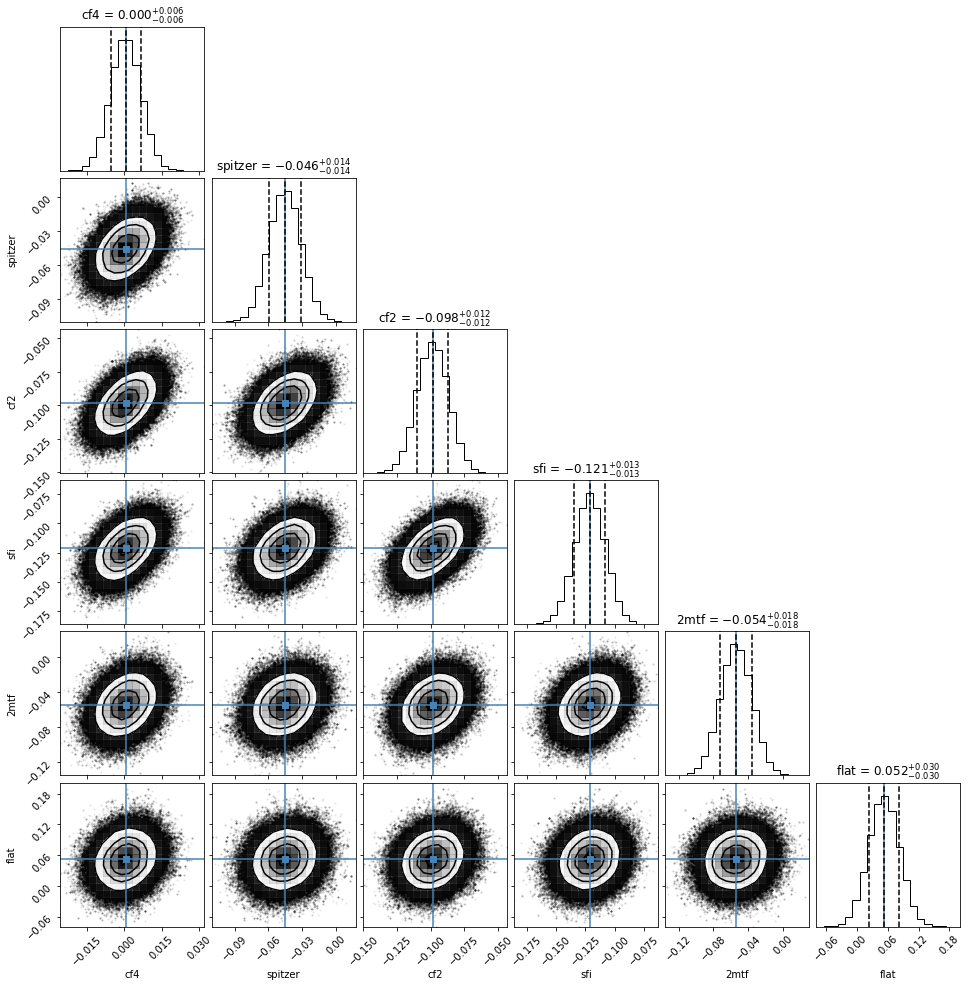

In [30]:
t1 =  datetime.now()
###########################################

ndim, nwalkers = len(catalogs), 64

p0 = [np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

sampler.reset()
sampler.run_mcmc(p0, 10000)
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))

theta = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                            zip(*np.percentile(samples, 
                            [16, 50, 84],
                            axis=0)))

truths=[t[0] for t in theta]
fig = corner.corner(samples, labels=catalogs, 
                    truths=truths, 
                    quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, 
                    title_kwargs={"fontsize": 12}, 
                    title_fmt=".3f")

###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

In [37]:
npzName = "CF4_cf2_spitzer_group.npz"
np.savez(npzName, samples)
npzfile = np.load(npzName)
print("npz attributes: ", npzfile.files)
NPZsamples = npzfile['arr_0']

('npz attributes: ', ['arr_0'])


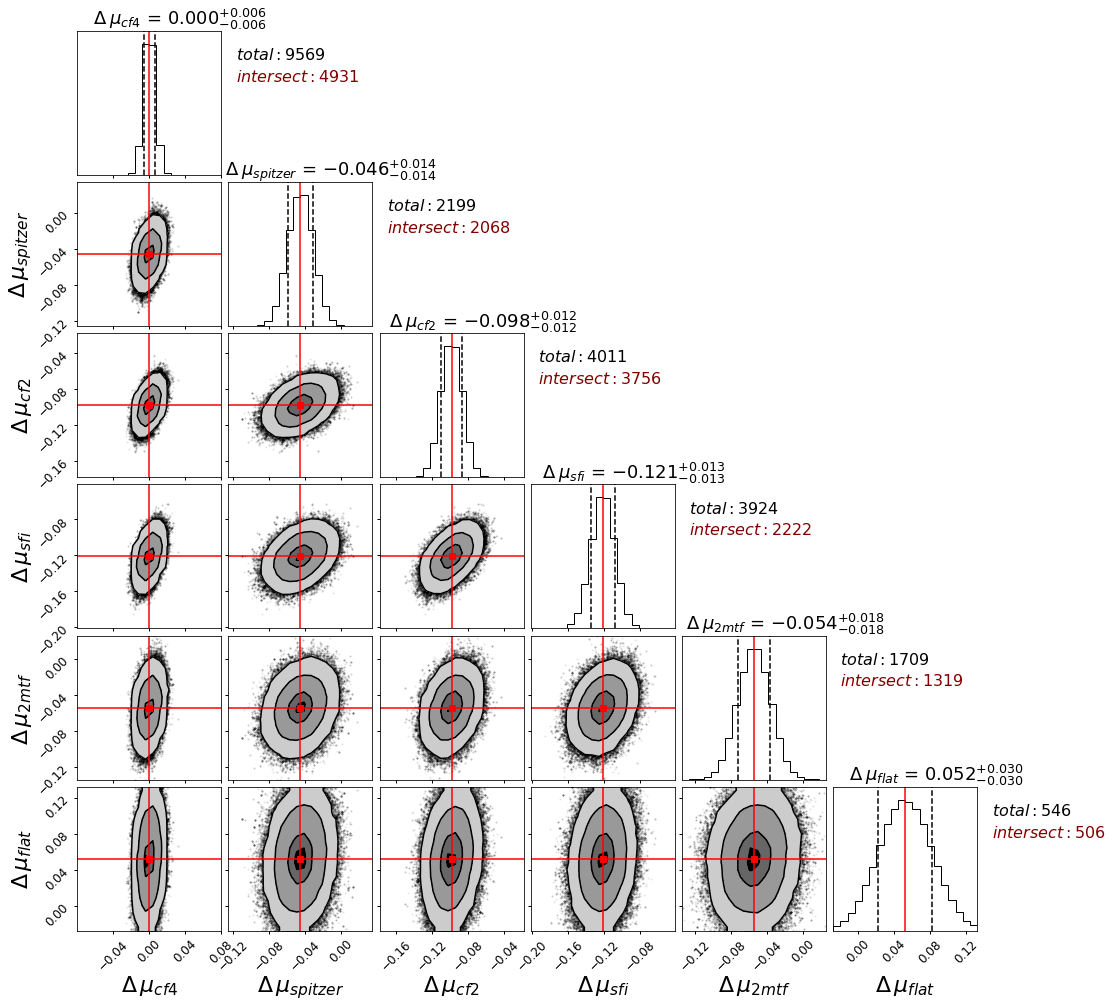

In [38]:
theta = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                            zip(*np.percentile(NPZsamples, 
                            [16, 50, 84],
                            axis=0)))

truths=[t[0] for t in theta]

labels = ['           '+r'$\Delta\/ \mu_{'+cat+'}$' for cat in catalogs]

fig = corner.corner(NPZsamples, labels=labels, 
                    truths=truths, truth_color='r',
                    levels=(1-np.exp(-1./8),1-np.exp(-0.5),1-np.exp(-0.5*4),1-np.exp(-0.5*9)),
                    show_titles=True, fill_contours=True, plot_density=True,
                    quantiles=[0.16, 0.84], 
                    scale_hist=False,space=0, 
                    title_kwargs={"fontsize": 18}, 
                    title_fmt=".3f",
                    range=[(t-0.08,t+0.08) for t in truths]
                   )

m = 0 
n_cat = len(catalogs)
i_cat = 0
for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=12)
    
    lbl = ax.xaxis.get_label()
    lbl.set_fontsize(22)
    txt = lbl.get_text().strip()
    lbl.set_text(txt)
    lbl.set_linespacing(50)
    lbl = ax.yaxis.get_label()
    lbl.set_fontsize(22)
    txt = lbl.get_text().strip()
    lbl.set_text(txt)    
    
    
    ax.tick_params(which='major', length=3, width=1., direction='out')
    
    Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
    x0 = -0.1*Xlm[0]+1.1*Xlm[1]
    
    if m%(n_cat+1)==0:
        y0 = 0.2*Ylm[0]+0.80*Ylm[1]
        dx = df[['DM_'+catalogs[i_cat]]].dropna()
        ax.text(x0,y0, r"$total: $"+str(len(dx)), fontsize=16, color='k')
        
        y0 = 0.35*Ylm[0]+0.65*Ylm[1]
        other_DMs = ["DM_"+c for c in catalogs if c != catalogs[i_cat]]
        
        df["sumDM"] = df[other_DMs].sum(axis=1)
        df["sumDM"][df["sumDM"]==0] = np.nan
        
        dx = df[['sumDM', 'DM_'+catalogs[i_cat]]].dropna()       
        ax.text(x0,y0, r"$intersect: $"+str(len(dx)), fontsize=16, color='maroon')
        i_cat += 1


    m+=1


